In [1]:
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


train_knn_embedding : pd.DataFrame = pd.read_pickle('../vul4c_dataset/train_knn_embedding.pkl')
test_knn_embedding : pd.DataFrame = pd.read_pickle('../vul4c_dataset/test_knn_embedding.pkl')
train_embeddings = np.vstack(train_knn_embedding['embedding'])
test_embeddings = np.vstack(test_knn_embedding['embedding'])

cluster_cnt = 6
cluster = KMeans(n_clusters=cluster_cnt,max_iter=1024,).fit(train_embeddings)
print(cluster)
print(dir(cluster))


/home/icy/miniconda3/envs/torch_new/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(max_iter=1024, n_clusters=6)
['__abstractmethods__', '__annotations__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_algorithm', '_check_feature_names', '_check_mkl_vcomp', '_check_n_features', '_check_params_vs_input', '_check_test_data', '_estimator_type', '_get_param_names', '_get_tags', '_init_centroids', '_more_tags', '_n_features_out', '_n_init', '_n_threads', '_parameter_constraints', '_repr_html_', '_repr_html_inner', '_repr_mimebundle_', '_sklearn_auto_wrap_output_keys', '_tol', '_transform', '_validate_center_shape', '_validate_data', '_validate_params', '_warn_mkl_vcomp', 'algorithm', 'cluster_centers_', 'copy_x', '

In [2]:
tsne = TSNE(n_components=2,)
tsne.fit_transform(np.concatenate([train_embeddings, cluster.cluster_centers_]))

array([[ 11.532256,   4.47803 ],
       [ 31.925886, -13.340848],
       [-38.38998 , -56.010162],
       ...,
       [ 37.095425, -16.370745],
       [ 28.323109,  40.145527],
       [-42.995953,  23.890604]], dtype=float32)

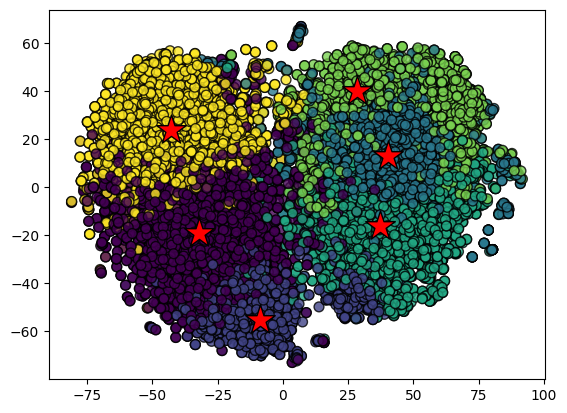

In [3]:

plt.scatter(
   tsne.embedding_[:-cluster_cnt, 0], tsne.embedding_[:-cluster_cnt, 1],
   edgecolor='black', s=50 , c = cluster.labels_ , alpha=0.8
)
plt.scatter(tsne.embedding_[-cluster_cnt:, 0],tsne.embedding_[-cluster_cnt:, 1],
        s=500, marker='*', label='centroids',  c='red',
        edgecolor='black',)


In [4]:
train_closest_to_cluster_center_idxs = pairwise_distances_argmin_min(cluster.cluster_centers_, train_embeddings)[0]   # closest to the cluster center points

# # convert to real id
train_closest_to_cluster_center_idxs = train_knn_embedding.iloc[train_closest_to_cluster_center_idxs]['id'].to_list()
#
# # [299873, 288754, 130831, 128642, 288445, 32049]
pd.DataFrame(train_closest_to_cluster_center_idxs).to_pickle('../vul4c_dataset/train_closest_to_center_idxs.pkl')


In [5]:
pairwise_distances_argmin_min(cluster.cluster_centers_, train_embeddings)
from sklearn.metrics import pairwise_distances
cosine_similarities = 1 - pairwise_distances(test_embeddings, train_embeddings, metric='cosine') # cosine similarity
np.fill_diagonal(cosine_similarities, 10) # some functions are too similar, fill diagonal value to 10
most_similar_idx = np.argsort(-cosine_similarities)[:, 1:21] # select top 20 similar items
similar_scores = np.take_along_axis(cosine_similarities, most_similar_idx, axis=-1)


In [6]:

similar_result = []
for i in tqdm(range(len(most_similar_idx))):
    row_idxs = most_similar_idx[i]
    row_idxs = train_knn_embedding.iloc[row_idxs]['id'].to_list()   # convert to real ids
    row_similar_score = similar_scores[i]
    similar_result.append(
        {
            'idxs' : list(row_idxs) ,
            'similar_scores' : list(row_similar_score)
        }
    )

print(f'similar result size:{len(similar_result)}')
pd.DataFrame(similar_result).to_pickle('../vul4c_dataset/test_similar_to_train.pkl')



100%|██████████| 38749/38749 [00:03<00:00, 12822.86it/s]


similar result size:38749
